# Preprocessing

## JSON $\rightarrow$ Pandas
Turning metadatas json into useful and readable pandas dataframes

in order to make this script work you need to have the dataset in the working wolder such as:
```
>> fds-2022-final-project
    >> ...
    >> og_dataset
        >> slices.json
        >> splits
            >> train/
            >> dev/
            >> test/
```

In [1]:
import json
import os
import numpy as np
import pandas as pd

metadata_file = 'og_dataset/slices.geojson'
train_folder = 'og_dataset/splits/train/'
dev_folder = 'og_dataset/splits/dev/'
test_folder = 'og_dataset/splits/test/'

We first import the json file, and take only the information regarding all the patches, while adding to it the center of the longitude and latitude of the patch

In [2]:
with open(metadata_file) as f:
    d = json.load(f)
patches = d['features']
patches = [{
    **p['properties'], 
     'lng':np.mean(p['geometry']['coordinates'][0][:-1], axis=0)[0],
     'lat':np.mean(p['geometry']['coordinates'][0][:-1], axis=0)[1]
    } for p in patches]
patches[:2]

[{'img_source': '/datadrive/glaciers/unique_tiles/LE07_149037_20041024.tif',
  'mask_source': '/datadrive/glaciers/processed/masks/mask_00.npy',
  'img_slice': '/datadrive/glaciers/processed/slices/slice_0_img_000.npy',
  'mask_slice': '/datadrive/glaciers/processed/slices/slice_0_mask_000.npy',
  'mask_mean_0': 0.0,
  'mask_mean_1': 0.0,
  'mask_mean_2': 0.0,
  'img_mean': 77.38898468017578,
  'lng': 333795.9649122807,
  'lat': 3572176.06391926},
 {'img_source': '/datadrive/glaciers/unique_tiles/LE07_149037_20041024.tif',
  'mask_source': '/datadrive/glaciers/processed/masks/mask_00.npy',
  'img_slice': '/datadrive/glaciers/processed/slices/slice_0_img_001.npy',
  'mask_slice': '/datadrive/glaciers/processed/slices/slice_0_mask_001.npy',
  'mask_mean_0': 0.0,
  'mask_mean_1': 0.0,
  'mask_mean_2': 0.0,
  'img_mean': 133.6044158935547,
  'lng': 348977.8947368421,
  'lat': 3572176.06391926}]

Now we port the dataset into pandas and clean it, by:
- taking the number of the original img it came from
- taking the slice number
- using the 2 aforemwntioned features as index
- drop the name of the original file it came from
- combine (sum) the mean of layer 0 and 1 of the mask together
- drop the mean of layer 0 and 1 of the mask (since those are now combined in `mask_mean`)
- rename the `mask_mean_2` as `china`, since it's the percentage of china represented in the image

In [3]:
metadata = pd.DataFrame(patches)
files_columns = ['img_source','mask_source','img_slice','mask_slice']
metadata[files_columns] = metadata[files_columns].applymap(lambda x: x.split('/')[-1])
metadata['src'] = metadata.img_slice.map(lambda s: s.split('_')[1])
metadata['slice_num'] = metadata.img_slice.map(lambda s: s.split('_')[-1][:3])
metadata.set_index(['src', 'slice_num'], inplace=True)
metadata['mask_mean'] = metadata.mask_mean_0 + metadata.mask_mean_1
metadata.rename(columns={'mask_mean_2':'china'}, inplace=True)
metadata.drop(columns=['img_source', 'mask_source', 'mask_mean_0', 'mask_mean_1'], inplace=True)

metadata.head()

img_slice            mask_slice  china    img_mean  \
src slice_num                                                                 
0   000        slice_0_img_000.npy  slice_0_mask_000.npy    0.0   77.388985   
    001        slice_0_img_001.npy  slice_0_mask_001.npy    0.0  133.604416   
    002        slice_0_img_002.npy  slice_0_mask_002.npy    0.0   94.324028   
    003        slice_0_img_003.npy  slice_0_mask_003.npy    0.0  189.766983   
    004        slice_0_img_004.npy  slice_0_mask_004.npy    0.0  198.229507   

                         lng           lat  mask_mean  
src slice_num                                          
0   000        333795.964912  3.572176e+06        0.0  
    001        348977.894737  3.572176e+06        0.0  
    002        364159.824561  3.572176e+06        0.0  
    003        379341.754386  3.572176e+06        0.0  
    004        394523.684211  3.572176e+06        0.0

Then we take the list of all the slice files for each folder

In [4]:
def list_files(folder):
    list_of_files = []

    for root, dirs, files in os.walk(folder):
        for file in files:
            list_of_files.append(file)
    return list_of_files

train_splits = list_files(train_folder)
dev_splits = list_files(dev_folder)
test_splits = list_files(test_folder)

test_splits[:3]

['slice_10_mask_174.npy', 'slice_10_mask_175.npy', 'slice_10_mask_187.npy']

And finally we partition the metadata in 3 different datasets

In [5]:
def partition_metadata(metadata, splits, folder = ''):
    # takes only the rows corresponding to those in the splits
    res = metadata[metadata.img_slice.isin( splits )].copy()
    # then adds the 
    res.img_slice = folder + res.img_slice
    res.mask_slice = folder + res.mask_slice
    return res

test_data = partition_metadata(metadata, test_splits, folder=test_folder)
dev_data = partition_metadata(metadata, dev_splits, folder=dev_folder)
train_data = partition_metadata(metadata, train_splits, folder=train_folder)

test_data.head()

img_slice  \
src slice_num                                               
1   151        og_dataset/splits/test/slice_1_img_151.npy   
2   093        og_dataset/splits/test/slice_2_img_093.npy   
    109        og_dataset/splits/test/slice_2_img_109.npy   
    157        og_dataset/splits/test/slice_2_img_157.npy   
3   004        og_dataset/splits/test/slice_3_img_004.npy   

                                                mask_slice     china  \
src slice_num                                                          
1   151        og_dataset/splits/test/slice_1_mask_151.npy  0.000000   
2   093        og_dataset/splits/test/slice_2_mask_093.npy  0.001530   
    109        og_dataset/splits/test/slice_2_mask_109.npy  0.020706   
    157        og_dataset/splits/test/slice_2_mask_157.npy  0.031021   
3   004        og_dataset/splits/test/slice_3_mask_004.npy  0.039127   

                 img_mean            lng           lat  mask_mean  
src slice_num                                                      
1   151        379.826019  460217.903596  4.200787e+06   0.521347  
2   093        525.524292  211011.702409  3.505949e+06   0.316036  
    109        510.207916  226193.617384  3.521131e+06   0.352470  
    157        537.625977  271739.362306  3.566677e+06   0.411125  
3   004        352.693176  654383.836999  3.417196e+06   0.201778

In [6]:
test_data.to_csv('dataset/test_data.csv')
train_data.to_csv('dataset/train_data.csv')
dev_data.to_csv('dataset/dev_data.csv')

Now, to load a dataset:

In [7]:
pd.read_csv('dataset/train_data.csv', index_col=['src','slice_num']).head()

img_slice  \
src slice_num                                                
1   150        og_dataset/splits/train/slice_1_img_150.npy   
    165        og_dataset/splits/train/slice_1_img_165.npy   
    168        og_dataset/splits/train/slice_1_img_168.npy   
    185        og_dataset/splits/train/slice_1_img_185.npy   
    186        og_dataset/splits/train/slice_1_img_186.npy   

                                                 mask_slice     china  \
src slice_num                                                           
1   150        og_dataset/splits/train/slice_1_mask_150.npy  0.000595   
    165        og_dataset/splits/train/slice_1_mask_165.npy  0.000000   
    168        og_dataset/splits/train/slice_1_mask_168.npy  0.000000   
    185        og_dataset/splits/train/slice_1_mask_185.npy  0.000000   
    186        og_dataset/splits/train/slice_1_mask_186.npy  0.000023   

                 img_mean            lng           lat  mask_mean  
src slice_num                                                      
1   150        382.686157  445035.967865  4.200787e+06   0.370186  
    165        370.955048  445035.967865  4.215970e+06   0.216293  
    168        437.918457  490581.775057  4.215970e+06   0.322586  
    185        448.878815  520945.646519  4.231152e+06   0.383347  
    186        349.251465  536127.582249  4.231152e+06   0.274628

## Extract infos from metadata
We now want to get some informations out of the JSONs we just worked with

### China percentage

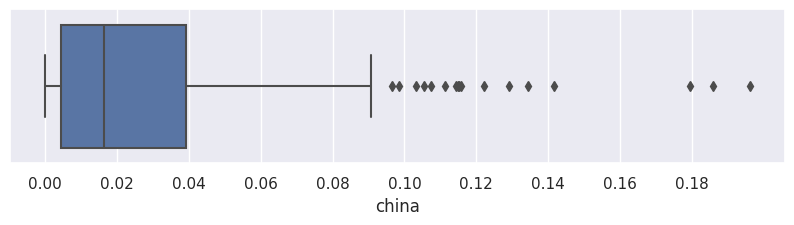

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
sns.set(rc={"figure.figsize":(10, 2)})

sns.boxplot(data=train_data, x='china')
plt.xticks(np.arange(0,train_data.china.max(), .02))
plt.show()

We can see that almost all of the values are in the range $(0, 0.04)$ and that only few outliers are above $0.1$.

## Create new Masks

We now want to read all the masks, which are $512 \times 512 \times 3$ `np.array` and we want to sum just the first 2 layers between themselves, as the layers of the array represent:
1. Clean-ice Glacier
2. Debris covered glacier
3. Is in china

We first load each matrix, but it appears some of the files are corrupted:

In [21]:
def load(file):
    try:
        return np.load(file)
    except:
        return pd.NA
    
test_data['np_mask'] = test_data.mask_slice.apply(lambda x: load(x))
train_data['np_mask'] = train_data.mask_slice.apply(lambda x: load(x))
dev_data['np_mask'] = dev_data.mask_slice.apply(lambda x: load(x))

Then we get the percentage of HKH in the patch, this differs from china for some reason

In [22]:
test_data['hkh_percentage'] = test_data.np_mask.map(lambda m: 1 - m[:,:,2].mean(), na_action='ignore')
dev_data['hkh_percentage'] = dev_data.np_mask.map(lambda m: 1 - m[:,:,2].mean(), na_action='ignore')
train_data['hkh_percentage'] = train_data.np_mask.map(lambda m: 1 - m[:,:,2].mean(), na_action='ignore')

Then we combine together the first 2 layers of the masks:

In [23]:
test_data.np_mask = test_data.np_mask.map(lambda m: np.logical_or(m[:,:,0], m[:,:,1]).astype(int), na_action='ignore')
train_data.np_mask = train_data.np_mask.map(lambda m: np.logical_or(m[:,:,0], m[:,:,1]).astype(int), na_action='ignore')
dev_data.np_mask = dev_data.np_mask.map(lambda m: np.logical_or(m[:,:,0], m[:,:,1]).astype(int), na_action='ignore')

Finally we compute the mean of each of the masks:

In [24]:
test_data.mask_mean = test_data.np_mask.map(lambda m: m.mean(), na_action='ignore')
train_data.mask_mean = train_data.np_mask.map(lambda m: m.mean(), na_action='ignore')
dev_data.mask_mean = dev_data.np_mask.map(lambda m: m.mean(), na_action='ignore')

train_data.head()

img_slice  \
src slice_num                                                
1   150        og_dataset/splits/train/slice_1_img_150.npy   
    165        og_dataset/splits/train/slice_1_img_165.npy   
    168        og_dataset/splits/train/slice_1_img_168.npy   
    185        og_dataset/splits/train/slice_1_img_185.npy   
    186        og_dataset/splits/train/slice_1_img_186.npy   

                                                 mask_slice     china  \
src slice_num                                                           
1   150        og_dataset/splits/train/slice_1_mask_150.npy  0.000595   
    165        og_dataset/splits/train/slice_1_mask_165.npy  0.000000   
    168        og_dataset/splits/train/slice_1_mask_168.npy  0.000000   
    185        og_dataset/splits/train/slice_1_mask_185.npy  0.000000   
    186        og_dataset/splits/train/slice_1_mask_186.npy  0.000023   

                 img_mean            lng           lat mask_mean  \
src slice_num                                                      
1   150        382.686157  445035.967865  4.200787e+06   0.18539   
    165        370.955048  445035.967865  4.215970e+06  0.108147   
    168        437.918457  490581.775057  4.215970e+06  0.161293   
    185        448.878815  520945.646519  4.231152e+06  0.191673   
    186        349.251465  536127.582249  4.231152e+06  0.137325   

                                                         np_mask  \
src slice_num                                                      
1   150        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
    165        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
    168        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
    185        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
    186        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

              hkh_percentage  
src slice_num                 
1   150              0.18539  
    165             0.108147  
    168             0.161293  
    185             0.191673  
    186             0.137325

In [25]:
# Strangely the hkh_percentage and the mask_mean on the first 2 layers are very very close:
(train_data.hkh_percentage - train_data.mask_mean).sum()

-0.13212966918945312

### Glaciers percentage
Finally we can see the distribution of percentages of glaciers

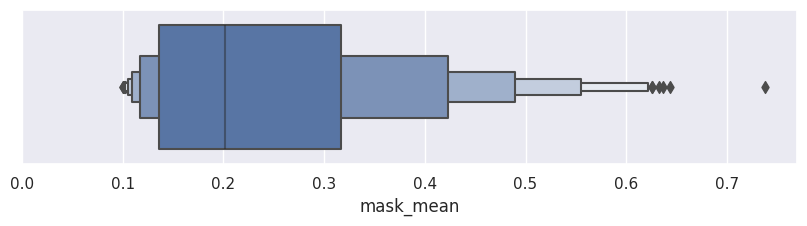

In [27]:
sns.boxenplot(data=train_data.dropna(), x='mask_mean' )
plt.xticks(np.arange(0,train_data.mask_mean.max(),0.1))
plt.show()

Aside from the data being a little strange since they are sometimes bigger than 1, I would say that the optimal choice for the **threshold** should be $0.2$.

In [46]:
dev_data\
    .reset_index()\
    .apply(lambda r: 
            np.save(f'dataset/masks/dev/slice_{r.src}_mask_{r.slice_num}.npy', r.np_mask),
           axis=1)
;

''